In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras.backend as K

from sklearn.model_selection import KFold
from keras.models import Model, Sequential
from keras import layers
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

In [2]:
from ipynb.fs.full.DatasetManage import read_and_store_data
from ipynb.fs.full.FeatureExtraction import feature_extraction
from ipynb.fs.full.ClassificationPerformanceIndexes import classificationPerformanceIndexes, printClassificationPerformanceIndexes
from ipynb.fs.full.ClassificationMethods import CompleteLSTM

Parameter

In [3]:
perfInd = ['Accuracy', 'Sensitivity', 'Specificity', 'Precision', 'F1 Score', 'MCC', 'Kappa', 'Time']
channels = ['FP1-F7', 'F7-T7','T7-P7', 'P7-O1', 'FP1-F3', 'F3-C3', 'C3-P3', 'P3-O1', 'FP2-F4', 'F4-C4', 'C4-P4', 'P4-O2', 'FP2-F8', 'F8-T8', 'T8-P8', 'P8-O2', 'FZ-CZ', 'CZ-PZ', 'seizure']

dataset = 'CHB_MIT'
csvImportFile = 'CHB.csv'
csvExportFile = 'CHB.csv'
sample_rate = 256
time_window = 2
step = time_window * sample_rate

test_ratio = 0.3

pca_tolerance = 0.9

undersampling_rate = 0.2

oversampling_neighbors = 11

k_fold = 5

csvAverageFile = 'Features.csv'

batch = 10
epochs = 100
dropout_percentage = 0.2
loss_function = 'mean_squared_error'
metric = 'accuracy'

Create Training and Test Data

In [4]:
def trainTestData (features, test_ratio, k_fold, perfInd):
    x = features.loc[:, features.columns != 'seizure']
    y = features['seizure']
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = test_ratio, shuffle = True)
    results = pd.DataFrame(columns = perfInd)
    kf = KFold(n_splits = k_fold, shuffle = True)
    return x_train, x_test, y_train, y_test, results, kf

Read and Store Data

In [5]:
print('Reading data from', csvImportFile)
df = pd.read_csv(csvImportFile, delimiter = ',', header = 0)

Reading data from CHB.csv


Feature Extraction 

In [6]:
# ft = feature_extraction(df, sample_rate, step, pca_tolerance, undersampling_rate, oversampling_neighbors)

Train and Test process

In [7]:
ft = pd.read_csv(csvAverageFile, delimiter = ',', header = 0)

In [8]:
x_train, x_test, y_train, y_test, results, kf = trainTestData (ft, test_ratio, k_fold, perfInd)

x_train = np.reshape(x_train.values, (x_train.shape[0], 1, x_train.shape[1]))
y_train = y_train.values.astype(int)
x_test = np.reshape(x_test.values, (x_test.shape[0], 1, x_test.shape[1]))
y_test = y_test.values.astype(int)

GRU

Create training and validation and test data

In [9]:
from sklearn.model_selection import train_test_split

def trainTestData_2 (features, perfInd):
    x = features.loc[:, features.columns != 'seizure']
    y = features['seizure']
    x_1, x_test, y_1, y_test = train_test_split(x, y, test_size = 0.3, random_state=42)
    x_train, x_val, y_train, y_val = train_test_split(x_1, y_1, test_size=0.2, random_state=42)
    results = pd.DataFrame(columns = perfInd)
    return x_train, x_test, y_train, y_test, x_val, y_val, results

In [10]:
x_train, x_test, y_train, y_test, x_val, y_val, results = trainTestData_2 (ft, perfInd)

x_train = np.reshape(x_train.values, (x_train.shape[0], 1, x_train.shape[1]))
y_train = y_train.values.astype(int)
x_val = np.reshape(x_test.values, (x_test.shape[0], 1, x_test.shape[1]))
y_val = y_test.values.astype(int)
x_test = np.reshape(x_test.values, (x_test.shape[0], 1, x_test.shape[1]))
y_test = y_test.values.astype(int)

print(np.shape(x_train))
print(np.shape(y_train))

(313, 1, 86)
(313,)


In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, LSTM, Dense
from keras import optimizers


model = Sequential()

# Aggiunta dello strato GRU
model.add(GRU(32, input_shape=(None,  x_train.shape[-1]), return_sequences=True))

# Aggiunta dello strato LSTM
model.add(LSTM(64))


# Aggiunta dello strato di output
model.add(Dense(1, activation='sigmoid'))

# Definisco l'ottimizzatore con il learning rate iniziale
initial_learning_rate = 0.001
optimizer = tf.keras.optimizers.SGD(learning_rate=initial_learning_rate)

# Definisco il learning rate schedule con decay lineare
decay_steps = 1000  # Numero di passi di addestramento dopo i quali applicare il decay
decay_rate = 0.1  # Tasso di decay
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate, decay_steps, decay_rate, staircase=True)

# Aggiunta dello strato di output
model.add(Dense(1, activation='sigmoid'))

# Compilazione del modello
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])


# Addestramento del modello con il learning rate modificato
history = model.fit(x_train, y_train, epochs=1000, batch_size=8, validation_data=(x_val, y_val), callbacks=[tf.keras.callbacks.LearningRateScheduler(lr_schedule)])

train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

epochs = range(len(train_loss))

plt.figure()
plt.plot(epochs, train_loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.figure()
plt.plot(epochs, train_acc, label='Training accuracy')
plt.plot(epochs, val_acc, label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.show()

model.summary()



Epoch 1/1000
40/40 [==============================] - 4s 21ms/step - loss: 0.7409 - accuracy: 0.4856 - val_loss: 0.7240 - val_accuracy: 0.5119 - lr: 0.0010
Epoch 2/1000
40/40 [==============================] - 0s 5ms/step - loss: 0.7397 - accuracy: 0.4856 - val_loss: 0.7228 - val_accuracy: 0.5119 - lr: 0.0010
Epoch 3/1000
40/40 [==============================] - 0s 5ms/step - loss: 0.7383 - accuracy: 0.4856 - val_loss: 0.7218 - val_accuracy: 0.5119 - lr: 0.0010
Epoch 4/1000
40/40 [==============================] - 0s 5ms/step - loss: 0.7371 - accuracy: 0.4856 - val_loss: 0.7209 - val_accuracy: 0.5119 - lr: 0.0010
Epoch 5/1000
40/40 [==============================] - 0s 5ms/step - loss: 0.7360 - accuracy: 0.4856 - val_loss: 0.7199 - val_accuracy: 0.5119 - lr: 0.0010
Epoch 6/1000
40/40 [==============================] - 0s 6ms/step - loss: 0.7349 - accuracy: 0.4856 - val_loss: 0.7189 - val_accuracy: 0.5119 - lr: 0.0010
Epoch 7/1000
40/40 [==============================] - 0s 5ms/step - l

1 layer (optimizer SGD)

Epoch 1/200
63/63 [==============================] - 3s 10ms/step - loss: 0.6339 - accuracy: 0.7572 - val_loss: 0.5846 - val_accuracy: 0.8333
Epoch 2/200
63/63 [==============================] - 0s 3ms/step - loss: 0.5881 - accuracy: 0.8051 - val_loss: 0.5453 - val_accuracy: 0.8571
Epoch 3/200
63/63 [==============================] - 0s 3ms/step - loss: 0.5505 - accuracy: 0.8339 - val_loss: 0.5132 - val_accuracy: 0.8750
Epoch 4/200
63/63 [==============================] - 0s 3ms/step - loss: 0.5195 - accuracy: 0.8530 - val_loss: 0.4863 - val_accuracy: 0.8869
Epoch 5/200
63/63 [==============================] - 0s 4ms/step - loss: 0.4932 - accuracy: 0.8658 - val_loss: 0.4635 - val_accuracy: 0.8988
Epoch 6/200
63/63 [==============================] - 0s 3ms/step - loss: 0.4706 - accuracy: 0.8690 - val_loss: 0.4441 - val_accuracy: 0.9048
Epoch 7/200
63/63 [==============================] - 0s 3ms/step - loss: 0.4513 - accuracy: 0.8850 - val_loss: 0.4273 - val_accuracy: 0.9048
Epoch 8/200


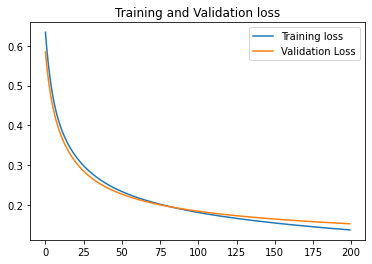

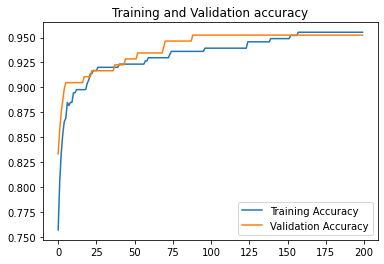

6/6 [==============================] - 0s 2ms/step - loss: 0.1534 - accuracy: 0.9524
Test Loss: 0.15338361263275146
Test Accuracy: 0.9523809552192688


In [11]:
from keras import optimizers


model = Sequential()
model.add(layers.GRU(32, input_shape=(None, x_train.shape[-1])))
model.add(layers.Dense(1, activation='sigmoid'))

#Definisco l'ottimizzatore con il learning rate iniziale
initial_learning_rate = 0.001
optimizer = tf.keras.optimizers.SGD(learning_rate=initial_learning_rate)

# Definisco il learning rate schedule con decay lineare
decay_steps = 1000  # Numero di passi di addestramento dopo i quali applicare il decay
decay_rate = 0.1  # Tasso di decay
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate, decay_steps, decay_rate, staircase=True)



model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])  # Utilizzo della binary cross-entropy per un problema di classificazione binaria

history = model.fit(x_train, y_train, batch_size=5, epochs=200, validation_data=(x_val, y_val))

loss = history.history['loss']
acc = history.history['accuracy']
val_loss = history.history['val_loss']
val_acc = history.history['val_accuracy']

epochs = range(len(loss))

plt.figure()
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()


plt.figure()
plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.title('Training and Validation accuracy')
plt.legend()
plt.show()

# Valutazione del modello
loss, accuracy = model.evaluate(x_test, y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)


In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 32)                11520     
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 11,553
Trainable params: 11,553
Non-trainable params: 0
_________________________________________________________________
